In [20]:
import seaborn as sns
sns.set(style="whitegrid")
from collections import Counter
from random import randint
import random
import warnings
warnings.filterwarnings('ignore')
from sklearn.cluster import KMeans
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [21]:
import os
if not os.path.exists("/content/football_data_clean2.csv"):
    os.symlink("/content/drive/My Drive/DataAnalytics/Clustering_Football/football_data_clean2.csv","/content/football_data_clean2.csv")  

# **Load Data and view samples**

In [22]:
import pandas as pd
import numpy as np

In [23]:
df=pd.read_csv('football_data_clean2.csv')
df.head()

,Unnamed: 0,Age,Overall,Potential,Value,Wage,International Reputation,Weak Foot,Skill Moves,Jersey Number,Height,Weight,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,0,31,94,94,110500000.0,565000.0,5.0,4.0,4.0,10.0,67.0,159.0,84.0,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,91.0,86.0,91.0,95.0,95.0,85.0,68.0,72.0,59.0,94.0,48.0,22.0,94.0,94.0,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0
1,1,33,94,94,77000000.0,405000.0,5.0,4.0,5.0,7.0,74.0,183.0,84.0,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,89.0,91.0,87.0,96.0,70.0,95.0,95.0,88.0,79.0,93.0,63.0,29.0,95.0,82.0,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0
2,2,26,92,93,118500000.0,290000.0,5.0,5.0,5.0,10.0,69.0,150.0,79.0,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,94.0,90.0,96.0,94.0,84.0,80.0,61.0,81.0,49.0,82.0,56.0,36.0,89.0,87.0,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0
3,3,27,91,93,72000000.0,260000.0,4.0,3.0,1.0,1.0,76.0,168.0,17.0,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,57.0,58.0,60.0,90.0,43.0,31.0,67.0,43.0,64.0,12.0,38.0,30.0,12.0,68.0,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0
4,4,27,91,92,102000000.0,355000.0,4.0,5.0,4.0,7.0,71.0,154.0,93.0,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,78.0,76.0,79.0,91.0,77.0,91.0,63.0,90.0,75.0,91.0,76.0,61.0,87.0,94.0,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0


In [24]:
df.columns

Index(['Unnamed: 0', 'Age', 'Overall', 'Potential', 'Value', 'Wage',
       'International Reputation', 'Weak Foot', 'Skill Moves', 'Jersey Number',
       'Height', 'Weight', 'Crossing', 'Finishing', 'HeadingAccuracy',
       'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy',
       'LongPassing', 'BallControl', 'Acceleration', 'SprintSpeed', 'Agility',
       'Reactions', 'Balance', 'ShotPower', 'Jumping', 'Stamina', 'Strength',
       'LongShots', 'Aggression', 'Interceptions', 'Positioning', 'Vision',
       'Penalties', 'Composure', 'Marking', 'StandingTackle', 'SlidingTackle',
       'GKDiving', 'GKHandling', 'GKKicking', 'GKPositioning', 'GKReflexes'],
      dtype='object')

# K-means 

**Normalize all the columns**

In [25]:
numerical_cols_dict={}

for i,col_name in enumerate(df.columns[1:]):
  numerical_cols_dict[col_name]=i
numerical_cols_dict  

{'Acceleration': 21,
 'Age': 0,
 'Aggression': 31,
 'Agility': 23,
 'Balance': 25,
 'BallControl': 20,
 'Composure': 36,
 'Crossing': 11,
 'Curve': 17,
 'Dribbling': 16,
 'FKAccuracy': 18,
 'Finishing': 12,
 'GKDiving': 40,
 'GKHandling': 41,
 'GKKicking': 42,
 'GKPositioning': 43,
 'GKReflexes': 44,
 'HeadingAccuracy': 13,
 'Height': 9,
 'Interceptions': 32,
 'International Reputation': 5,
 'Jersey Number': 8,
 'Jumping': 27,
 'LongPassing': 19,
 'LongShots': 30,
 'Marking': 37,
 'Overall': 1,
 'Penalties': 35,
 'Positioning': 33,
 'Potential': 2,
 'Reactions': 24,
 'ShortPassing': 14,
 'ShotPower': 26,
 'Skill Moves': 7,
 'SlidingTackle': 39,
 'SprintSpeed': 22,
 'Stamina': 28,
 'StandingTackle': 38,
 'Strength': 29,
 'Value': 3,
 'Vision': 34,
 'Volleys': 15,
 'Wage': 4,
 'Weak Foot': 6,
 'Weight': 10}

In [26]:
k=2
max_iterations=100
tolerance=0.0001

**Distance Metrics**

In [86]:
def getEuclideanDistance(point, centroid):
    return np.linalg.norm(point-centroid)

def getManhattanDistance(point, centroid):
    return np.sum(np.abs(point-centroid))

def getCosineDistance(point, centroid):
    return np.dot(point,centroid)

In [28]:
getEuclideanDistance(np.array([1,0]),np.array([0,1]))

1.4142135623730951

**Intialize k random points from given data as centroids**

In [105]:
def initRandomCentroids(X,k):
  rows,cols=X.shape  
  centroids={}
  random_rows=random.sample(range(rows), 3)
  for i,row_index in enumerate(random_rows):
    centroids[i]=X[row_index]
  return centroids 

**Function to find closest centroid**

In [144]:
def getNearestCentroidIndex(point, centroids): 
      distances = [getEuclideanDistance(point, centroids[centroid]) for centroid in centroids] 
      return distances.index(min(distances)) # returns index of nearest point

**Find the distance between the current point and the cluster**

In [130]:
#Find closest centroid for each data sample.Associate with index
def createNewClusters(X,centroids,k):

  classes={}
  for i in range(k):
    classes[i] = []
  for current_sample in X:
    centroid_index = getNearestCentroidIndex(current_sample ,centroids)
    classes[centroid_index].append(current_sample)
  return classes   

**Recompute the centroids of new clsuters**

In [111]:
def RecalculateCentroids(clusters):
	centroids={}
	for cluster in clusters:
		centroids[cluster] = np.average(clusters[cluster], axis = 0)
	return centroids	

**Nromalize the data**

In [34]:
numerical_cols = [cname for cname in df.columns[1:] if  df[cname].dtype in ['int64', 'float64']]

# Keep selected columns only
X_data = df[numerical_cols].copy()
X_data.shape

from sklearn.preprocessing import normalize
X_data = normalize(X_data)

**Applying PCA for dimensionality reduction**

In [36]:
from sklearn.decomposition import PCA
pca = PCA(n_components=9)
X_data_pca = pca.fit_transform(X_data)

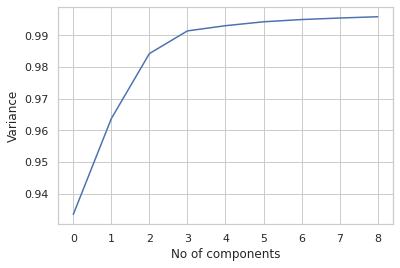

In [37]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('No of components')
plt.ylabel('Variance');

Reduced dimension to 9 from ~80 features with above 99% variance retention 

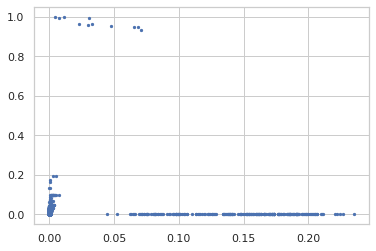

In [40]:
col1=numerical_cols_dict['Aggression']
col2=numerical_cols_dict['Wage']
plt.scatter(X_data[:,col1], X_data[:,col2], s=5)

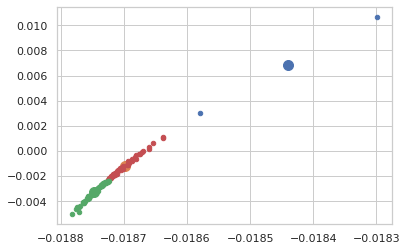

In [154]:
def hasConverged(curr,original_centroid,tolerance):
   return np.sum((curr - original_centroid)/original_centroid * 100.0) < tolerance

def fit(data,k,tolerance,max_iterations):

	centroids = {}

	#Intialize with random centroids
	centroids=initRandomCentroids(data,k)

	#Loop until converagnce within given tolerance or maximum iterations
	for i in range(max_iterations):
    #Create clusters
		labels = createNewClusters(data,centroids,k)
		prev_centroids = centroids
		#Recalculate centroid for each cluster
		centroids=RecalculateCentroids(labels)    

	  #Check if converged
		for centroid in centroids:
			current_centroid = prev_centroids[centroid]
			curr = centroids[centroid]
			if hasConverged(curr,current_centroid,tolerance):
				break
	return centroids,labels


X = X_data_pca[:100]

k_list=[3,5,7]
k =3
tolerance = 0.001
max_iterations = 10

centroids,labels=fit(X,k,tolerance,max_iterations)

colors = ["b", "r", "g", "y", "k"]

for centroid in centroids:
  plt.scatter(centroids[centroid][0], centroids[centroid][1], s = 100, marker = "o")

for label in labels:
  color = colors[label]
  for features in labels[label]:
    plt.scatter(features[0], features[1], color = color,s = 20)

plt.show()

**Elbow method for selection of number of clusters**

k=10 is suitable

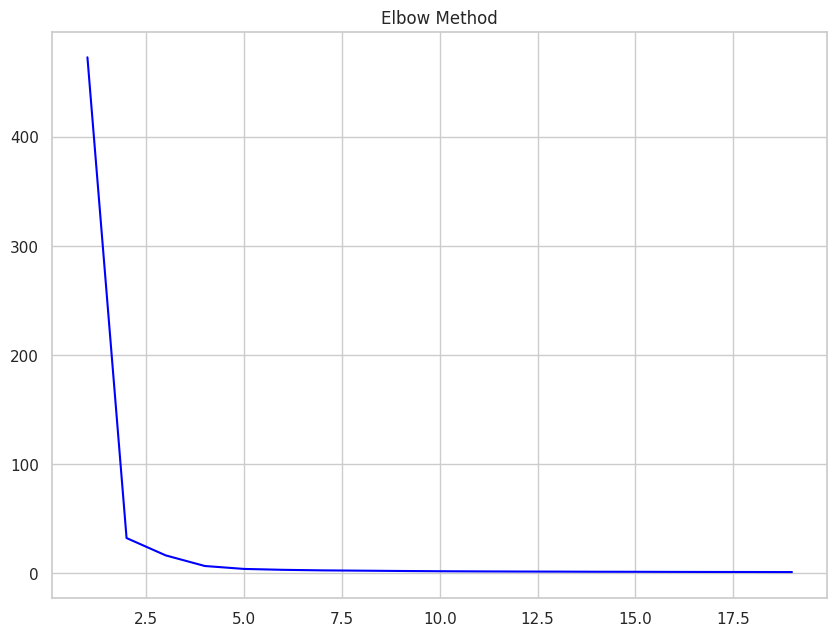

In [163]:
import seaborn as sns
from sklearn.cluster import KMeans
inertia_list=[]
k_list=range(1, 20)
for k in k_list:
    kmeans = KMeans(n_clusters = k, init = 'k-means++', random_state = 101)
    kmeans.fit(X_data_pca)
    inertia_list.append(kmeans.inertia_)
plt.plot(k_list, elbow,color='blue')

plt.title('Elbow Method')
plt.show()

**Silhouette Score**


It used to study the separation distance between the resulting clusters. 

Provides a measure between [-1,1] on how a point in one cluster is close to neighboring cluster

For n_clusters = 2 The average silhouette_score is : 0.6156086269067027
For n_clusters = 3 The average silhouette_score is : 0.5525763250584856
For n_clusters = 4 The average silhouette_score is : 0.5513307107876322
For n_clusters = 5 The average silhouette_score is : 0.5132533385415697
For n_clusters = 6 The average silhouette_score is : 0.5220020832254452
For n_clusters = 7 The average silhouette_score is : 0.5463033981631011
For n_clusters = 8 The average silhouette_score is : 0.5428765198519513
For n_clusters = 9 The average silhouette_score is : 0.5360552634769613
For n_clusters = 10 The average silhouette_score is : 0.5281981258571831
For n_clusters = 11 The average silhouette_score is : 0.5246245190893811
For n_clusters = 12 The average silhouette_score is : 0.5290942335865559
For n_clusters = 13 The average silhouette_score is : 0.5153250631530323
For n_clusters = 14 The average silhouette_score is : 0.5118078214244242
For n_clusters = 15 The average silhouette_score is : 0.532

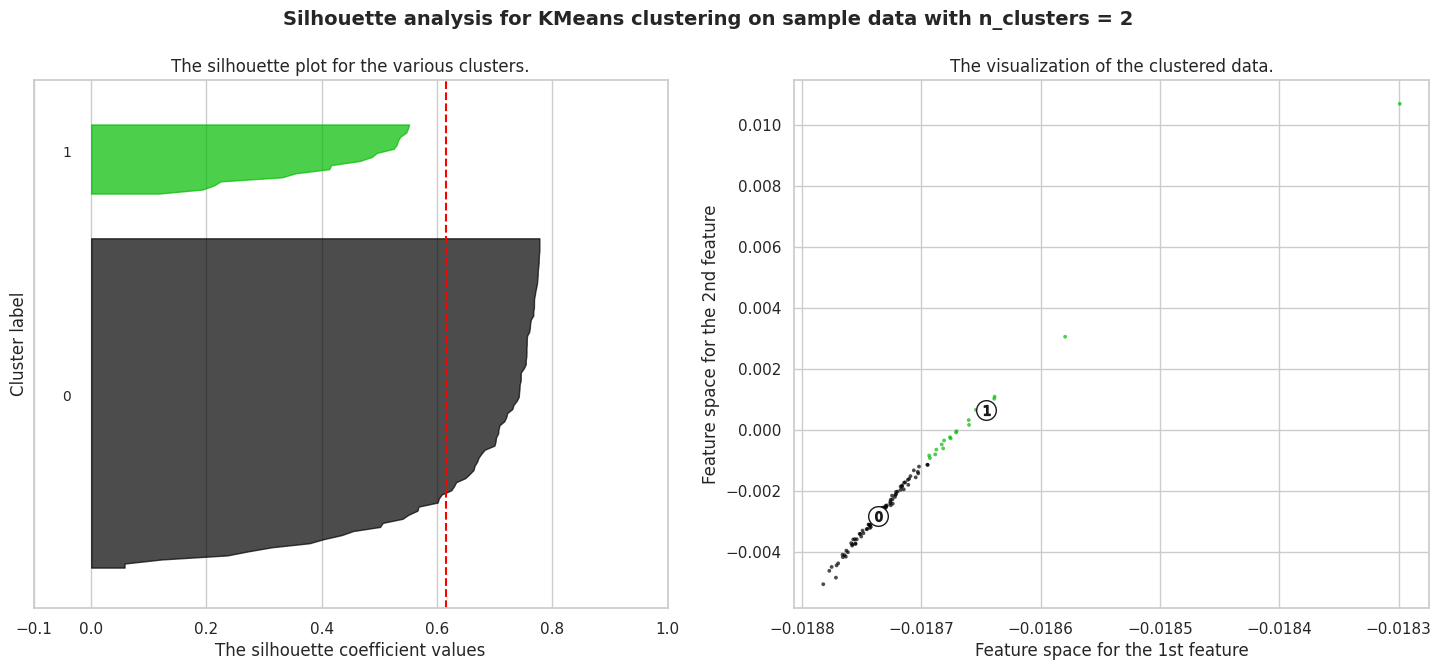

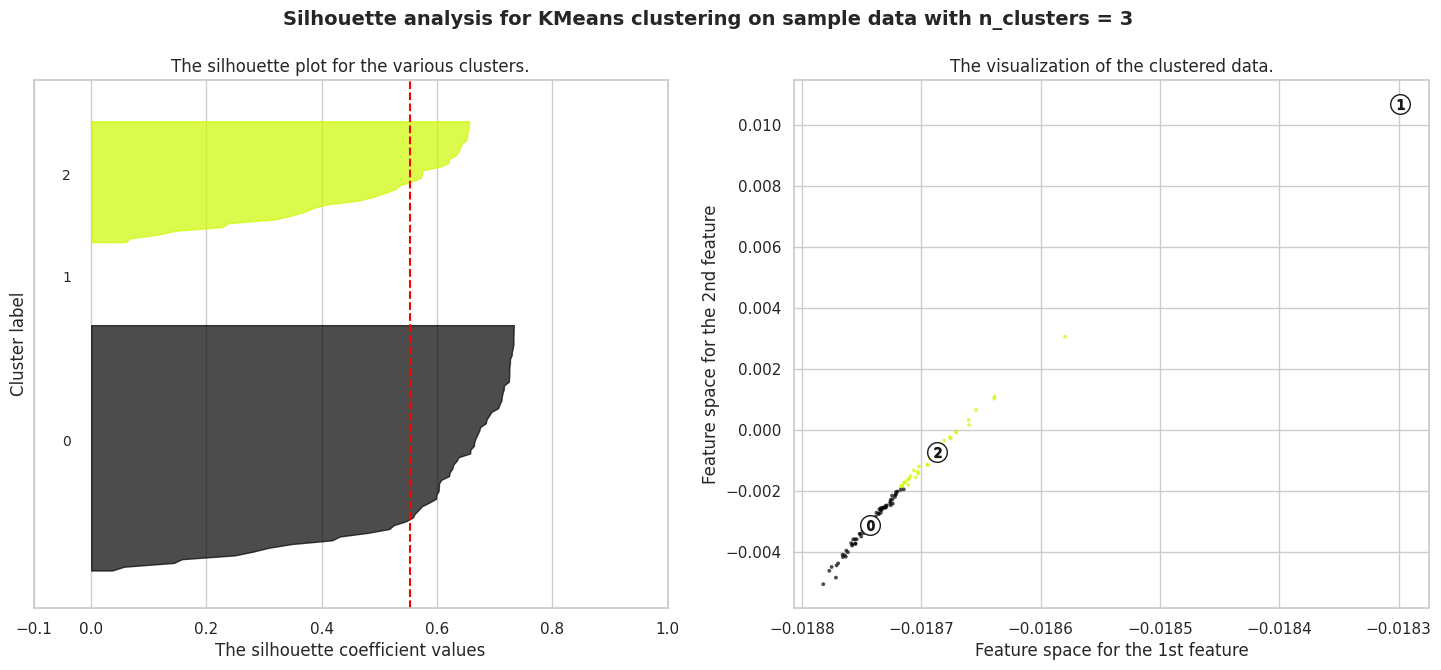

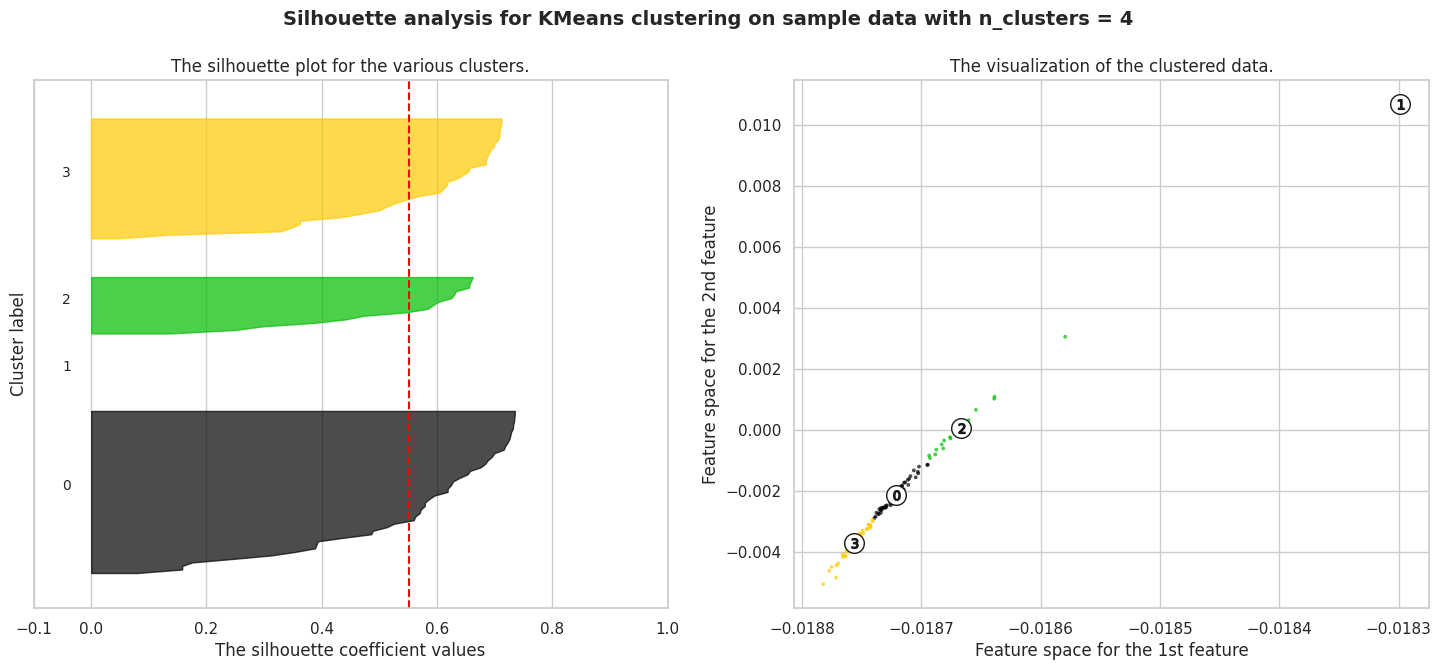

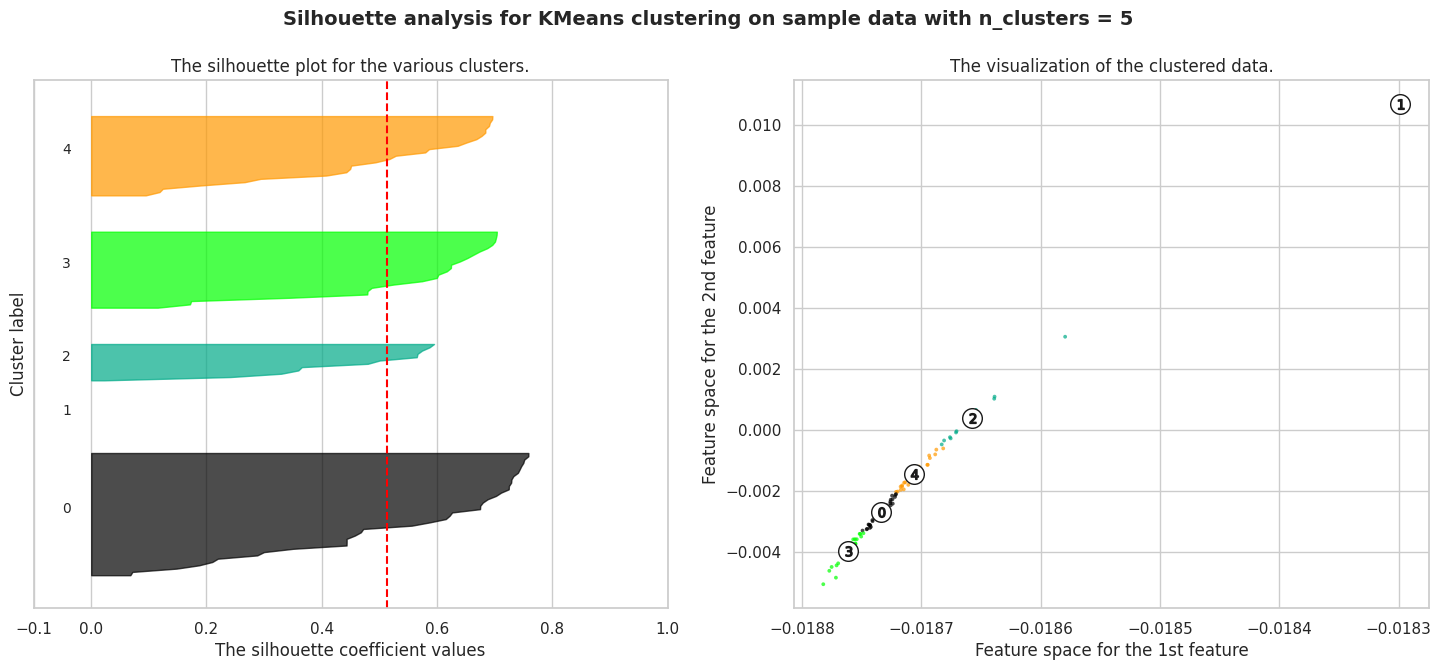

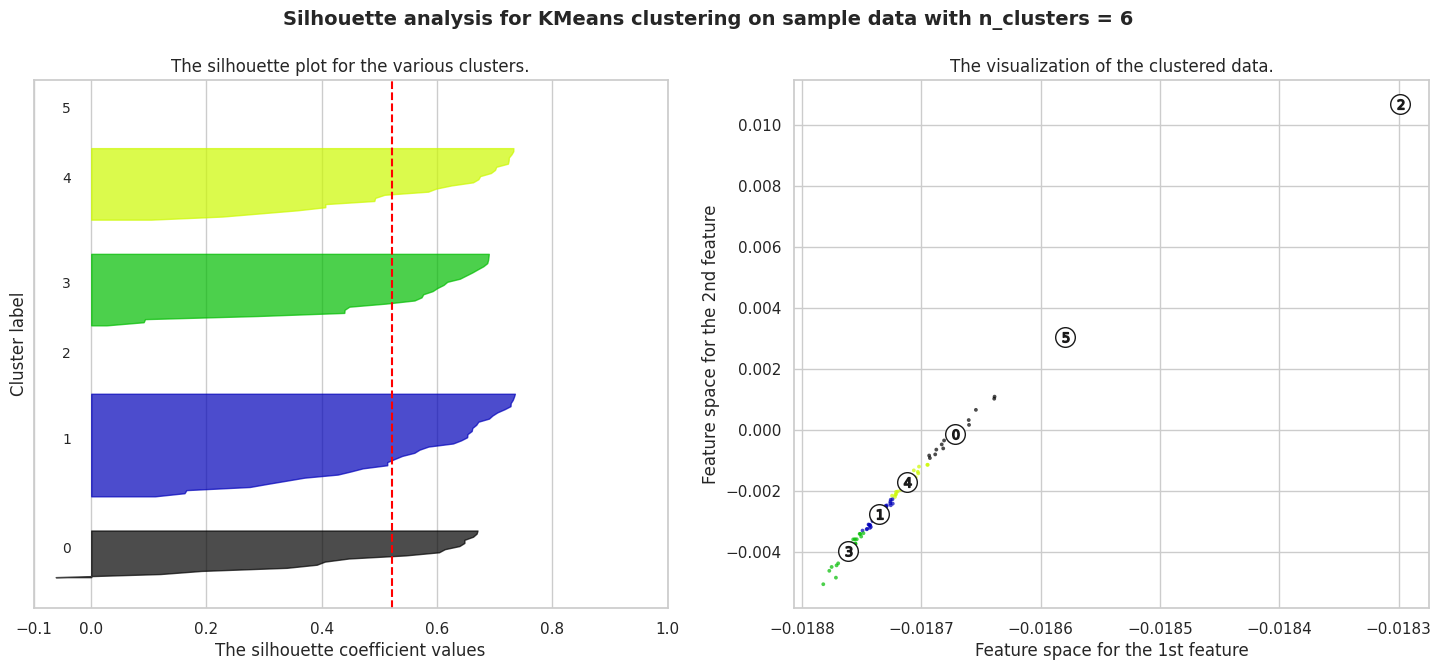

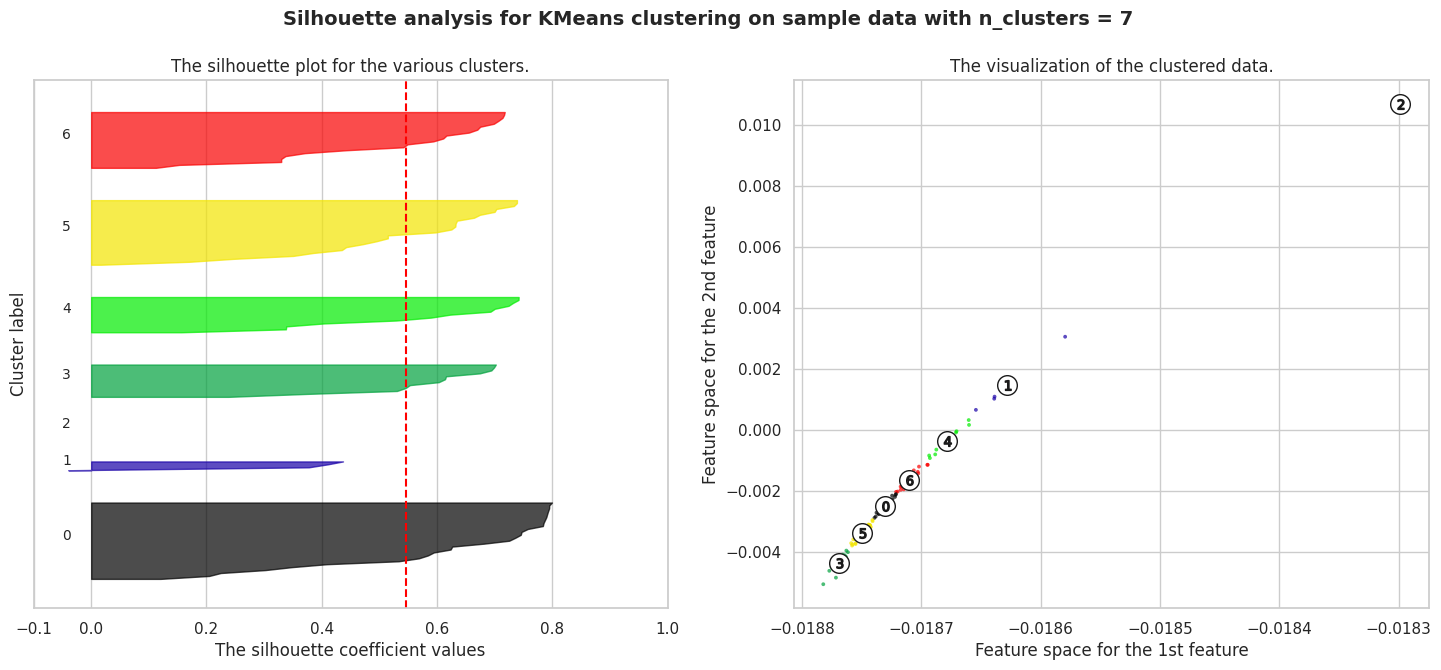

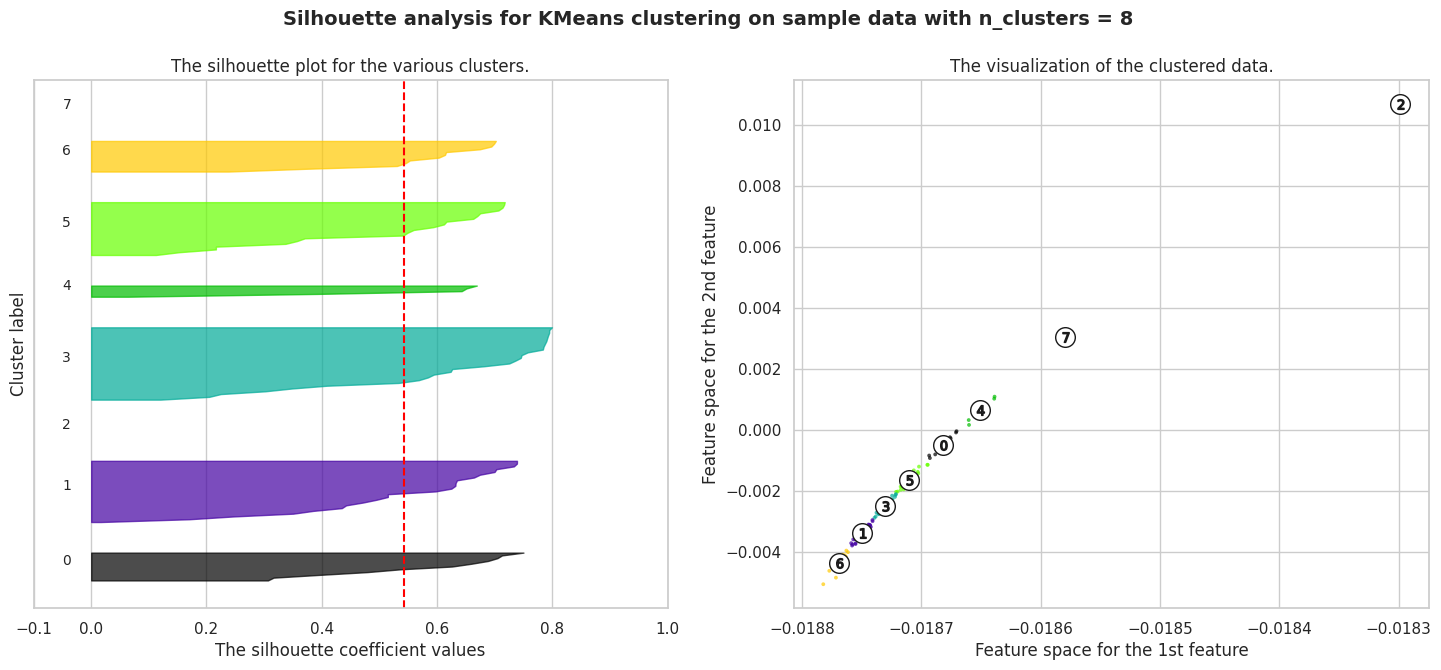

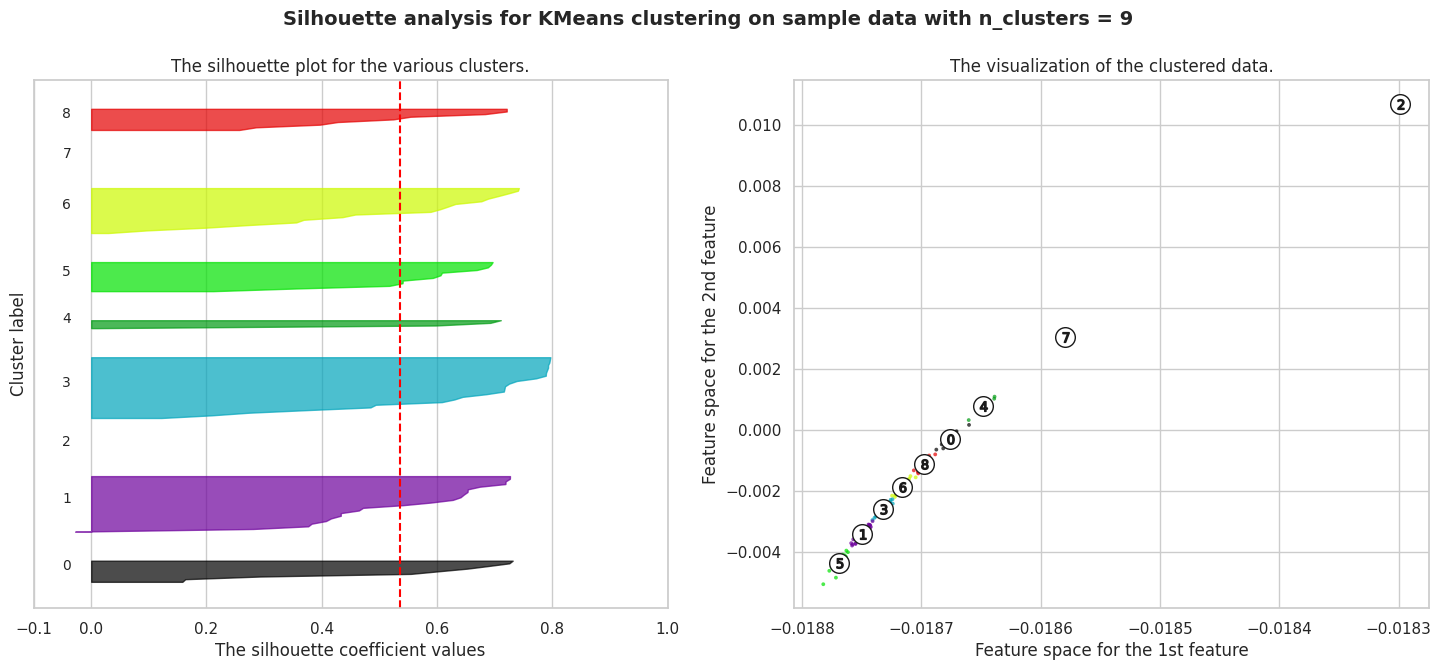

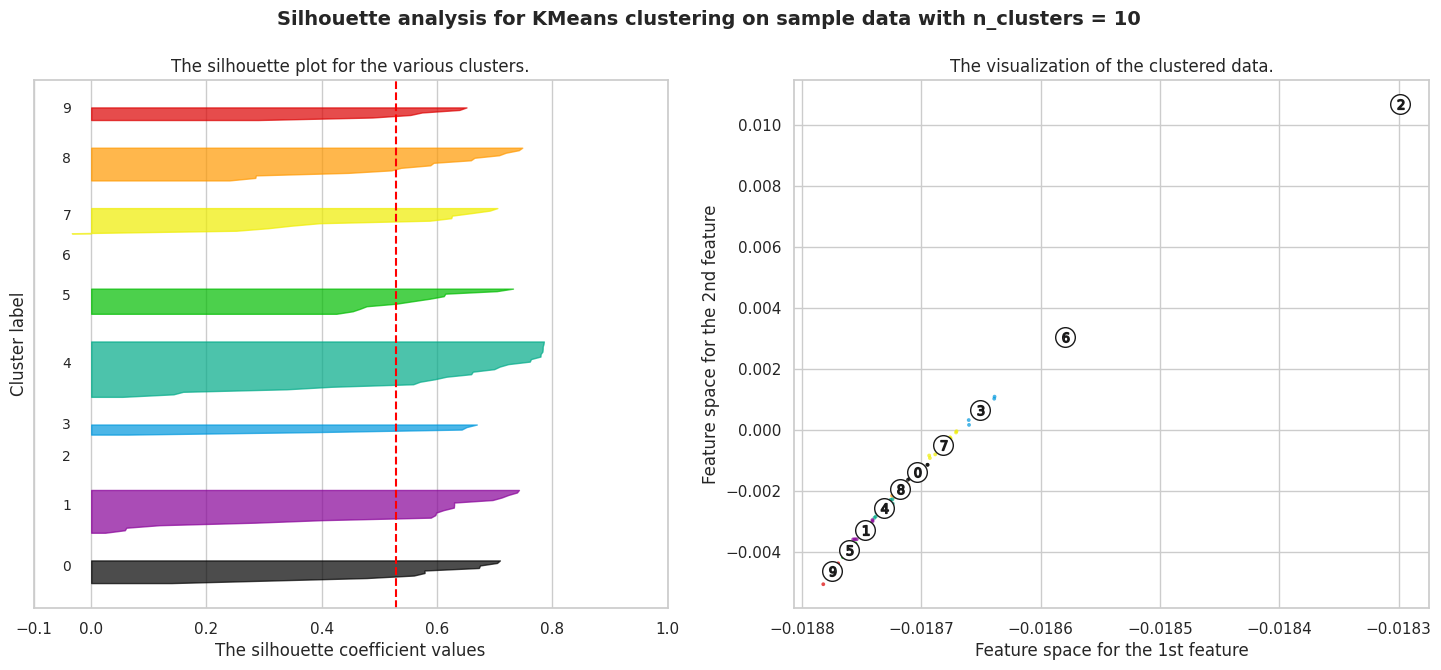

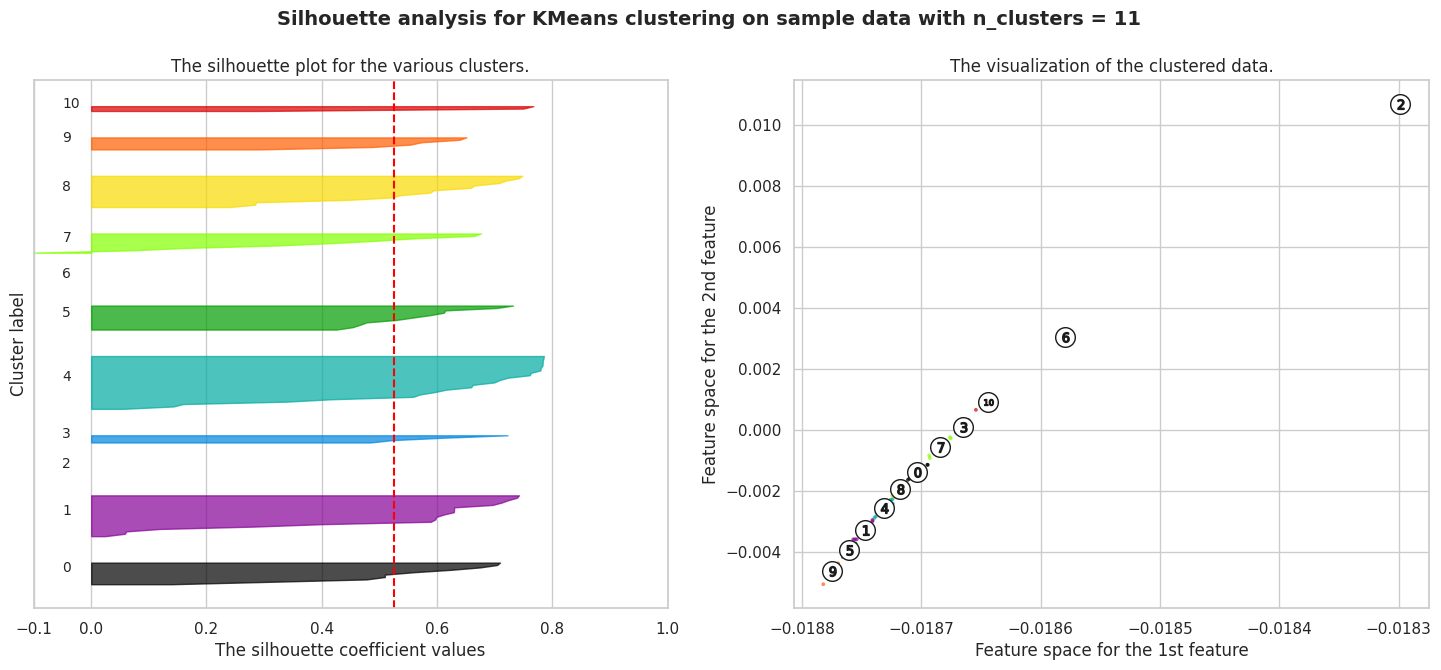

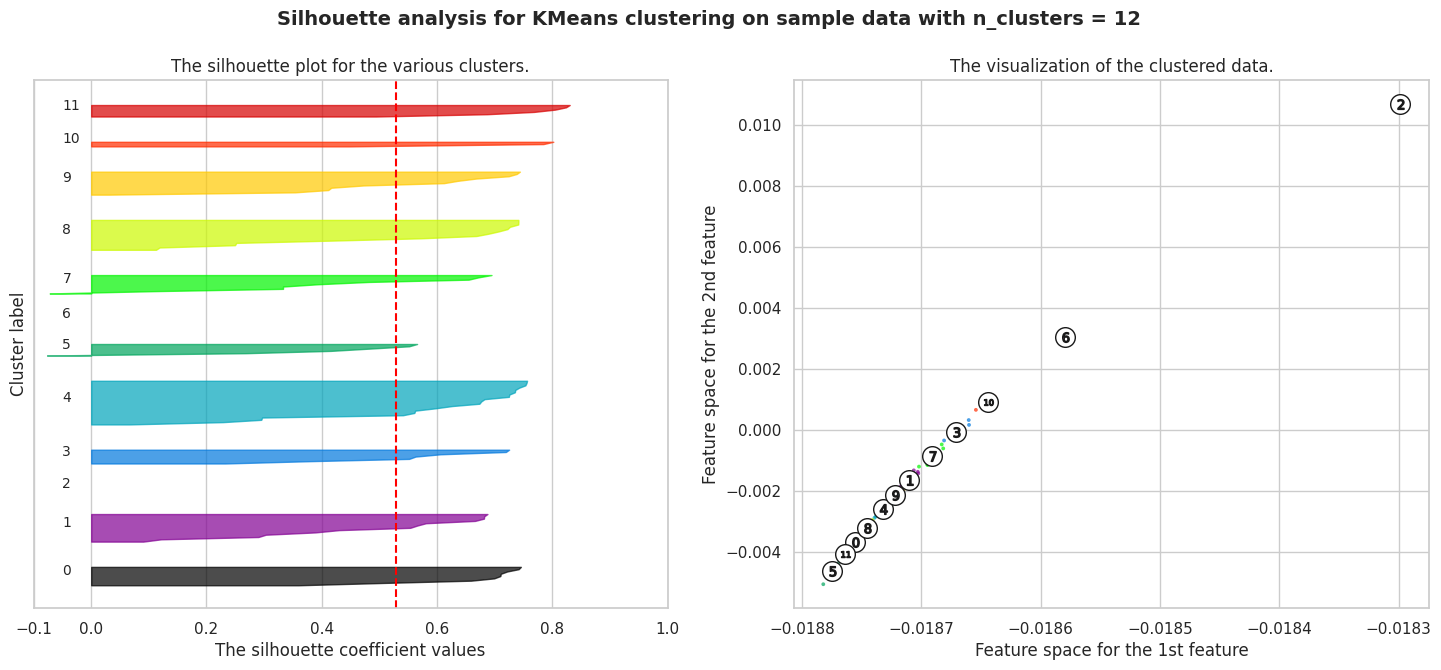

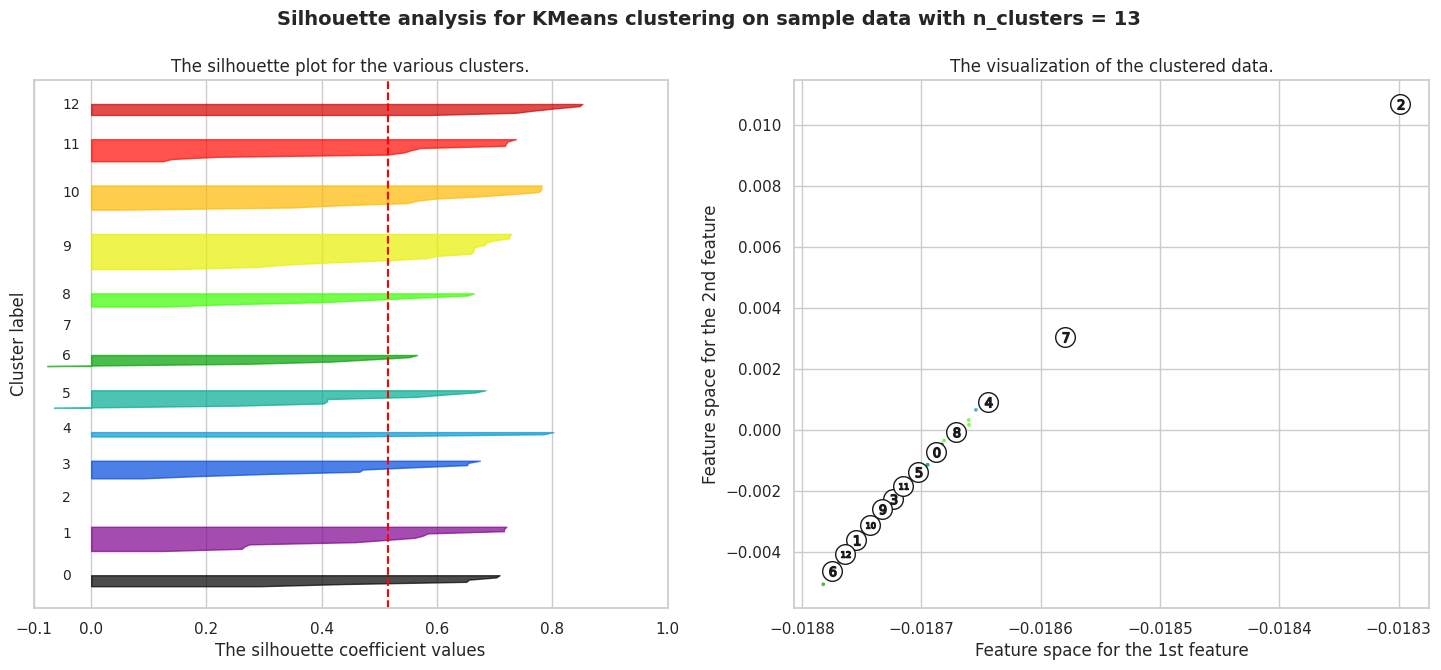

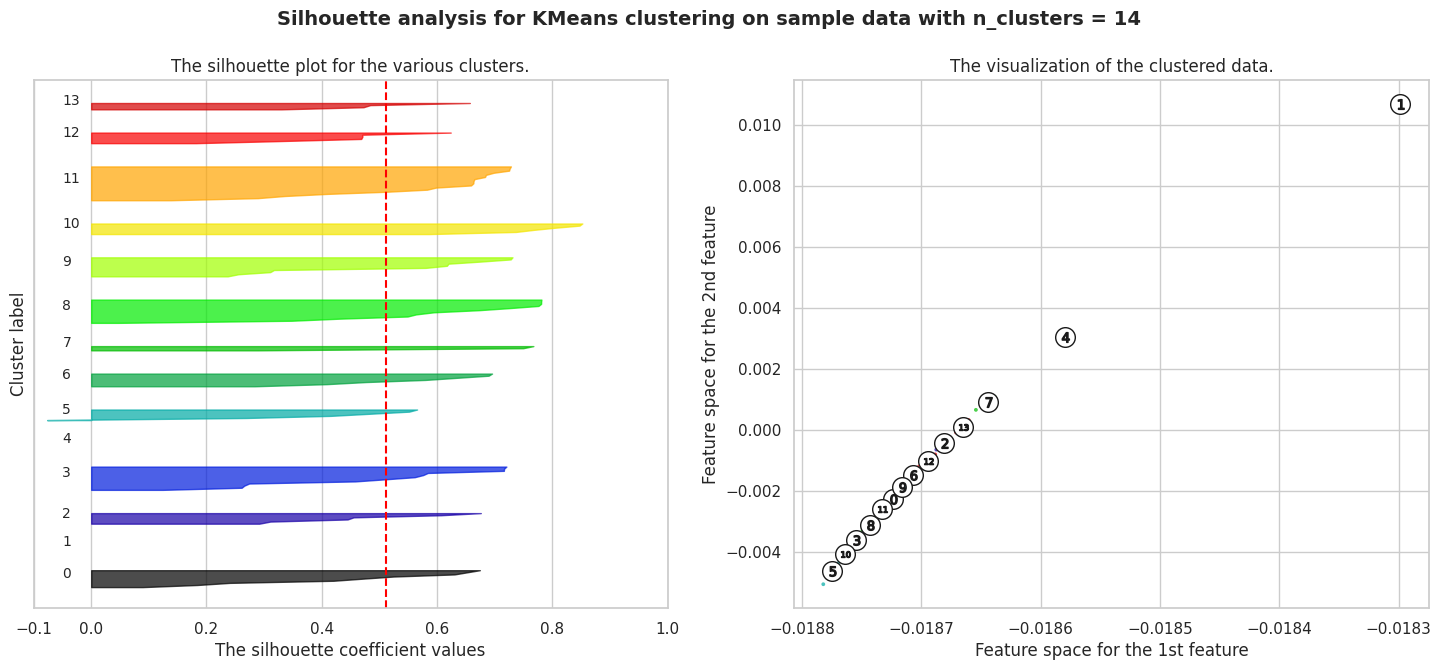

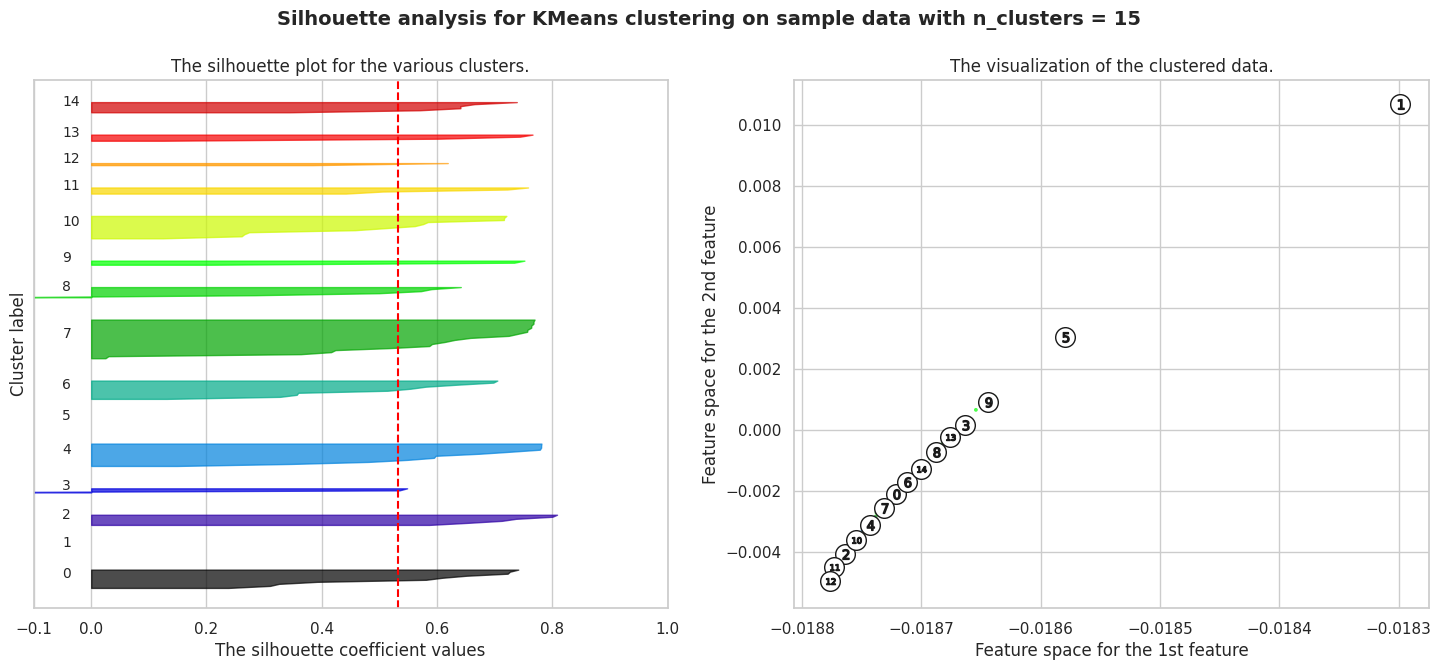

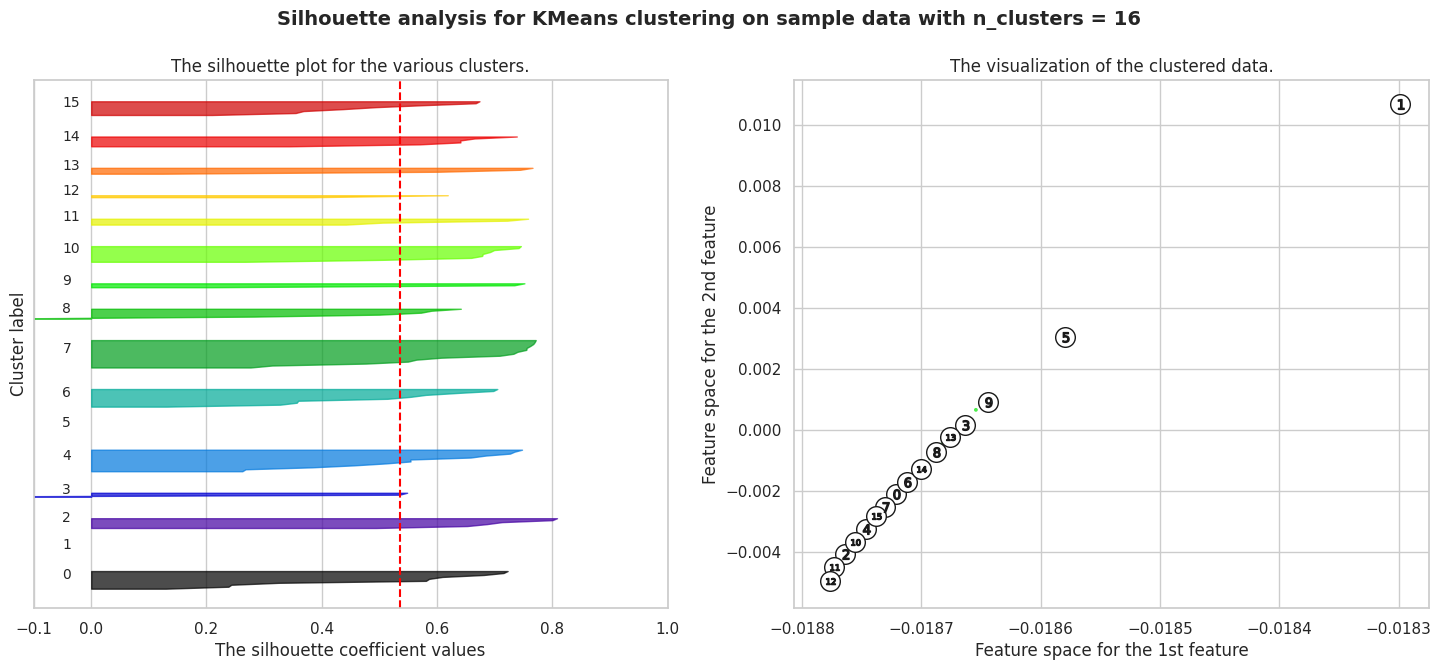

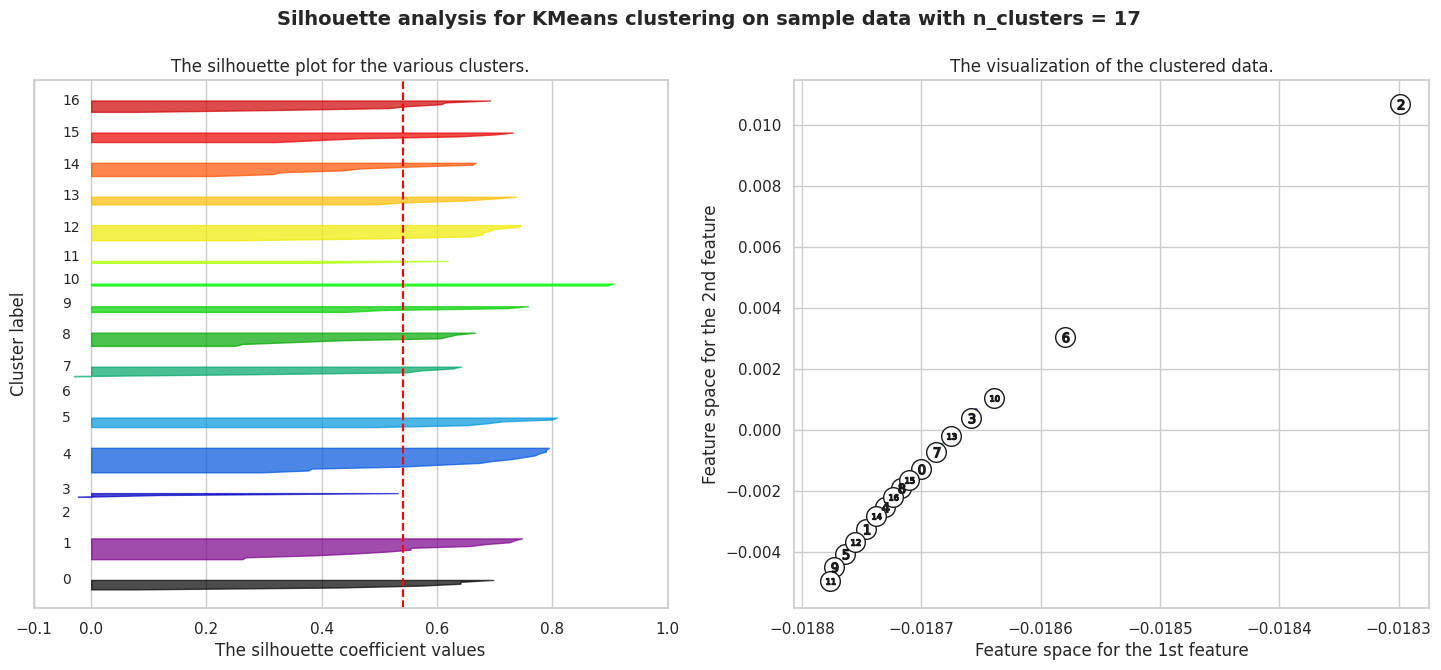

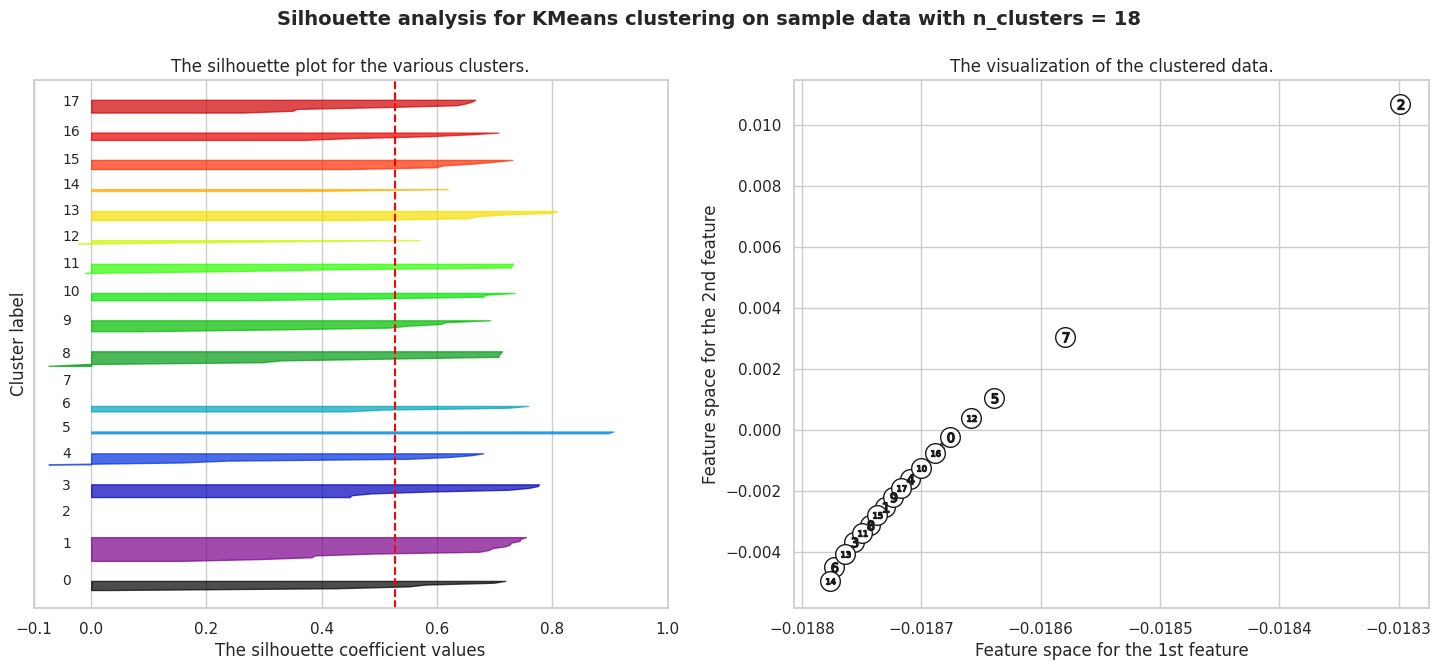

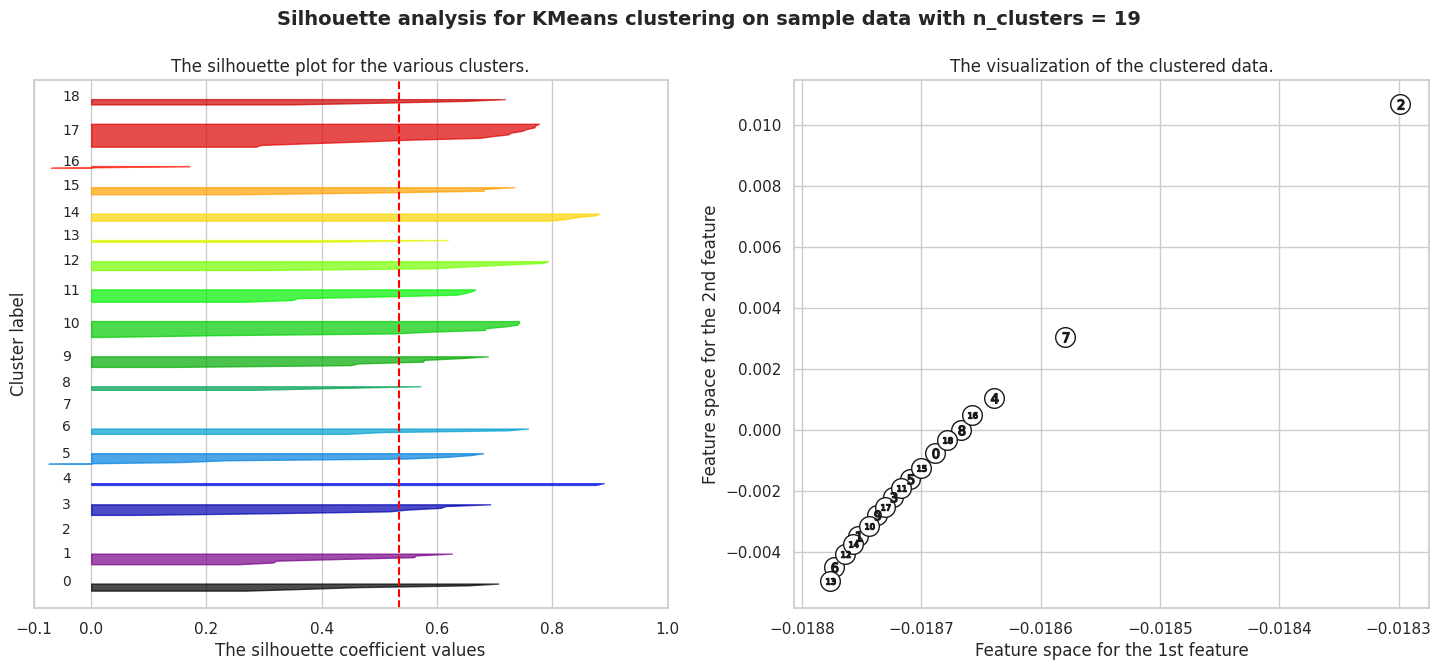

In [169]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
range_n_clusters = range(2,20)

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

**Analyse the results got in every case and try to mark each cluster.**